# Data cleanning

In this notebook we will use few filters/techniques to clean images data so it will be ready for modeling.

Keep in mind that these cleanning techniques are very picky and they generally suits very large datasets whose ready to lose about 50% of the data in total.
Our approach was to crawl as much data as possible (even trash data) and then to clean it aggressively.

At first step,
we will use ResNet50 network to clean all the images that there without dogs. This step is very important because there is no point training the model on images without dogs.
(The ResNet50 cleanning notebook can be found at: https://github.com/adids1221/Dog-Breed-Classification/blob/main/data_cleaning/ResNet50%20Data%20Cleaning.ipynb) 

At the second step,
we noticed that big part of our images were drawings, and not photos, which probably will affect the model and disturb it when training, thus, we decided to detect the drawing with entropy.
We found out that in avarage, drawing's entropy is way lower than real photo's entropy, so we made a function that detects every images from the dataset whose has entropy below 4.3 and deleting it.
We also noticed that photos with dogs on a uniform backgroud tend to have the same entropy value as drawings, so, we did a little trick which is actually to eliminate the most frequent value in all images, and only then calculate the entoropy value (What it did is to "remove" the uniform backgroud from the photo because we assumed that the backgroud is the most frequent value/color in an image like that".

At third step, 
We calculated the avarage outliers amount for each class, how we did that?
1.Calculate the mean of an image and flatten it
2.Calculate the IQR 40-60 of that image
3.Sum all IQRs values of all images of the class and devide by number of images of that class
After we had the avarage outliers of a class we decided to eliminate some of the classes due proccessing power limitaion.
We took into account the avarages distribution and the distribition of images count of each class.

At forth step,
We calculated and plotted the intensitiy distribution of the images for each class and also for the whole data itself. 

At fifth step,
We deleted all the images of each class, whose have above the avarage outliers in comparision to the class avarage.

At sixth step,
We calculated and plotted the intensitiy distribution of the images for each class and also for the whole data itself after cleanning to check if we made a good job (the overall intesnitiy decreased)

In [16]:
from sklearn.datasets import load_files   

from tensorflow import keras 
from keras.utils import np_utils
import numpy as np
from glob import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import statistics
import math
from scipy.stats import iqr
import cv2
import numpy as np
from matplotlib import pyplot as plt
import statistics
import math
from scipy.stats import iqr
import os
import collections
import operator
from collections import OrderedDict
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

import matplotlib.pyplot as plt
from skimage import io
from skimage.measure.entropy import shannon_entropy
from skimage.filters.rank import entropy
from skimage.morphology import disk

# Functions

In [4]:
def load_csv(file_name):
    df = pd.read_csv(file_name)
    return df

def display_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    return imgplot

def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t           

    avg = sum_num / len(num)
    return avg

def plot_image_intensity_distb(img_path):
    im = cv2.imread(img_path)
    # calculate mean value from RGB channels and flatten to 1D array
    vals = im.mean(axis=2).flatten()
    # plot histogram with 255 bins
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])
    plt.show()
    display_img(img_path)

def plot_image_intensity_rgb(df_image, label):
    img = cv2.imread(df_image)
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
        
    print(dog_names[np.argmax(label)])
    print(img.shape)
    plt.show()
    #plt.imshow(img)
    display_img(df_image)
    
def plot_class_intensity_distb(path_to_class_folder):
    vals=[]
    imgs_path = np.array(glob(f"{path_to_class_folder}/*"))
    for img in imgs_path:
        im=cv2.imread(img)
        im=cv2.resize(im,(200,200))
        vals.append(im.mean(axis=2).flatten())
    summed_arr=np.sum(vals,axis=0)
    summed_arr=summed_arr/len(imgs_path)
    b, bins, patches = plt.hist(summed_arr, 255)
    plt.xlim([0,255])
    plt.show()
    

#plot all classes intensity ditb, save image, and return an array (summed an normalized) of all data distb
def plot_class_intensity_distb1(path_to_father_folder):
    classes = np.array(glob(f"{path_to_father_folder}/*"))
    fig = plt.figure(figsize=(12,18), dpi= 100, facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    vals=[]
    avarage_all_classes_list=[]
    dirname = os.path.basename(classes[0])

    for i in range(1, 13):
        summed_arr=return_class_intensity_array(classes[i-1])
        avarage_all_classes_list.append(summed_arr)
        print("done"+ (classes[i-1]))

        dirname = os.path.basename(classes[i-1])
        plt.subplot(4, 3, i)
        b, bins, patches = plt.hist(summed_arr, 255)
        plt.xlim([0,255])
        plt.title(dirname)
        plt.savefig('EMG {0}.jpg'.format(i))

    summed_classes_arr=np.sum(avarage_all_classes_list,axis=0)        
    summed_classes_arr=summed_classes_arr/len(avarage_all_classes_list)
    plt.show()
    return summed_classes_arr   

In [5]:
#function returns how many outliers are in an image
def find_img_intensity_iqr_40_60(img_path):
    im = cv2.imread(img_path)
    #print(img_path)
    # calculate mean value from RGB channels and flatten to 1D array
    vals = im.mean(axis=2).flatten()
    iqr_image=iqr(vals,rng=(40, 60))
    return iqr_image
        
    
#function returns the avarge iqr of a class 
def iqrs_average_of_a_class(folder_path):
    imgs_mean_vals=[]
    imgs_path = np.array(glob(f"{folder_path}/*"))
    
    for img in imgs_path:
       # print(img)
        iqr_single_img=find_img_intensity_iqr_40_60(img) #find single iqr of single image
        imgs_mean_vals.append(int(iqr_single_img)) #append all iqr of all images in a list
        
    return sum(imgs_mean_vals) / len(imgs_mean_vals)


#retuns paths of imgs that are above avarage + paths top 5 imgs with lowest iqr + paths of top 5 images with highest iqr
def paths_of_img_that_are_above_iqr_average_of_a_class_and_two_lists(folder_path):
    imgs_iqr_above_avarge_paths=[]
    top_5_lowest_iqr_imgs={"path_1":255,"path_2":255,"path_3":255,"path_4":255,"path_5":255}
    top_5_highest_iqr_imgs={"path_1":0,"path_2":0,"path_3":0,"path_4":0,"path_5":0}
    
    avarage=iqrs_average_of_a_class(folder_path)
    
    imgs_path = np.array(glob(f"{folder_path}/*"))
    
    for img in imgs_path:
        iqr_single_img=find_img_intensity_iqr_40_60(img) #find single iqr of single image
        if(iqr_single_img>avarage):
            imgs_iqr_above_avarge_paths.append(img)
            
        for k,v in top_5_lowest_iqr_imgs.items(): #update 5 lowest list
            if(iqr_single_img<v): #if the current iqr is smaller then the smallest, replace it
                top_5_lowest_iqr_imgs[k]=iqr_single_img
                top_5_lowest_iqr_imgs[img] = top_5_lowest_iqr_imgs.pop(k) #here we change the key, means, update the path
                top_5_lowest_iqr_imgs=sort_dict(top_5_lowest_iqr_imgs) #here we sort the dict so next time it will be easier
                break
               
        for k,v in top_5_highest_iqr_imgs.items():
            if(iqr_single_img>v): #if the current iqr is smaller then the smallest, replace it
                top_5_highest_iqr_imgs[k]=iqr_single_img
                top_5_highest_iqr_imgs[img] = top_5_highest_iqr_imgs.pop(k) #here we change the key, means, update the path
                top_5_highest_iqr_imgs=des_sort_dict(top_5_highest_iqr_imgs) #here we desending-sort the dict so next time it will be easier
                print("")
                break
    return imgs_iqr_above_avarge_paths, top_5_lowest_iqr_imgs, top_5_highest_iqr_imgs
 
    
#returns average iqr of X classes
def retruns_avarge_iqr_of_x_classes(path_to_main_folder): #structure= path_to_main_folder->{{class a}->{1img_class_a,2img_class_a},{class b}->{1img_class_b,2img_class_b}
    
    avrages_dict={}
    folders_path= np.array(glob(f"{path_to_main_folder}/*"))
    
    for folder in folders_path:
        avrages_dict[(folder.rsplit("/",maxsplit=1)[1])]=iqrs_average_of_a_class(folder)
        print(avrages_dict)
         
    return avrages_dict


def sort_dict(unsorted_dict):
    sorted_tuples = sorted(unsorted_dict.items(), key=operator.itemgetter(1))
    sorted_dict = OrderedDict()
    for k, v in sorted_tuples:
        sorted_dict[k] = v
    return sorted_dict


def des_sort_dict(unsorted_dict):
    des_sorted_tuples = sorted(unsorted_dict.items(), key=operator.itemgetter(1),reverse=True)
    des_sorted_dict = OrderedDict()
    for k, v in des_sorted_tuples:
        des_sorted_dict[k] = v
    return des_sorted_dict
 
    
#plot sorted dict
def plot_dict(dic,to_sort=True):
    if(to_sort==True):
        sorted_dict=sort_dict(dic)
    keys = sorted_dict.keys()
    values = sorted_dict.values()
    plt.figure(figsize=(35, 8))  # width:20, height:3
    plt.ylabel("Avarage Outliers", fontsize=30)
    plt.bar(keys, sorted_dict.values(), align='center',width=0.7)

    
#plots images horizontally if you input list of 
def showImagesHorizontally(list_of_imgs_pahts, count=0 ):
    fig = figure(figsize=(20, 20), dpi=80)
    if (count ==0):
        number_of_files=len(list_of_imgs_pahts)
    else:
        number_of_files = count
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_imgs_pahts[i])
        imshow(image,cmap='Greys_r')
        axis('off')

        
def extract_paths_from_a_dic_and_return_as_files(dic):
    list_of_files=[]
    for k,v in dic.items():
        list_of_files.append(cv2.imread(k))
    return list_of_files


def extract_paths_from_a_dic_and_return_as_list(dic):
    list_of_paths=[]
    for k,v in dic.items():
         list_of_paths.append(k) 
    return list_of_paths


def paths_of_drawings_of_a_class(path_to_class_folder):
    img_path_list=[]
    imgs_path = np.array(glob(f"{path_to_class_folder}/*"))
    for img_path in imgs_path:
        print(img_path)
        img = cv2.imread(img_path)
        valueToBeRemoved = np.bincount(img.flatten()).argmax() #most common value
        myImg = [value for value in img.flatten() if value != valueToBeRemoved] #remove most common value
        ent=shannon_entropy(myImg)
        print(ent)
        if(ent<4.3):
            img_path_list.append(img_path)   
    return img_path_list  


def clean_drawings_from_all_classes(path_to_father_folder):
    list_of_paths_to_remove=[]
    classes = np.array(glob(f"{path_to_father_folder}/*"))
    for breedClassPath in classes:
        list_of_paths_to_remove.extend(paths_of_drawings_of_a_class(breedClassPath))
    return list_of_paths_to_remove


def img_delete(img_list):
    counter = 0
    for img in img_list:
        try:
            os.remove(img)
            counter+=1
        except:
            print("There was an error deleting the file: %"%(img))
    
def return_class_intensity_array(path_to_class_folder):
    vals=[]
    imgs_path = np.array(glob(f"{path_to_class_folder}/*"))
    for img in imgs_path:
        im=cv2.imread(img)
        im=cv2.resize(im,(200,200))
        vals.append(im.mean(axis=2).flatten())
    summed_arr=np.sum(vals,axis=0)
    summed_arr=summed_arr/len(imgs_path)
    return summed_arr


def return__list_of_paths_of_images_above_avg_ouliers_to_delete_plus_paths_to_best_and_wrost(father_dic_path):
    classes_paths = np.array(glob(f"{father_dic_path}/*"))
    images_paths_to_delete_that_are_above_avarage_of_all_classes=[]
    five_images_paths_that_are_ABOVE_avarge_of_all_classes=[]
    five_images_paths_that_are_BELOW_avarge_of_all_classes=[]

    for class_path in classes_paths:
            imgs_iqr_above_avarge_paths, top_5_lowest_iqr_imgs,top_5_highest_iqr_imgs=paths_of_img_that_are_above_iqr_average_of_a_class_and_two_lists(class_path)

            images_paths_to_delete_that_are_above_avarage_of_all_classes.append(imgs_iqr_above_avarge_paths)
            five_images_paths_that_are_ABOVE_avarge_of_all_classes.append(top_5_highest_iqr_imgs)
            five_images_paths_that_are_BELOW_avarge_of_all_classes.append(top_5_lowest_iqr_imgs)

    return images_paths_to_delete_that_are_above_avarage_of_all_classes,five_images_paths_that_are_ABOVE_avarge_of_all_classes,five_images_paths_that_are_BELOW_avarge_of_all_classes



def plot_entp(image_path):
    img = cv2.imread(image_path) #path to the image
    fig = plt.figure(figsize=(25, 25), dpi=80)
    fig.add_subplot(rows, columns, 1)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img)

    print(img.shape) # show dimension of image
    dim1, dim2 = img.shape[0], img.shape[1]
    num_channels = img.shape[2]


    valueToBeRemoved = np.bincount(img.flatten()).argmax() #most common value -> delete 
    myList = [value for value in img.flatten() if value != valueToBeRemoved] #remove most common value

    
    #print(myList[0])
    myList = np.array(RGB_img)
    print(shannon_entropy(myList)) 
    
    entr_img = entropy(RGB_img[:,:,0], disk(10))
    fig.add_subplot(rows, columns, 2)
    plt.imshow(entr_img, cmap='viridis')
    plt.show()
    
    
def save_list_to_a_file(list_):
    with open('your_file.txt', 'w') as f:
        for item in list_:
            f.write("%s\n" % item)

            
def return_list_of_lists_of_rows_from_a_df_and_lists_of_eow_labels(file_path):
    labels=[]
    df=load_csv(file_path)
    df_list = df.values.tolist()
    for i in range(len(df_list)):
        labels.append(df_list[i][0])
        del df_list[i][0]    
    return df_list,labels 
    

def create_stack_plot (df_list,labels):
    x = list(range(1,30))
    y = np.vstack(df_list)
    pal = ["#9bc363", "#0c9191", "#e3bc81", "#9b4065","#482b58"]
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.stackplot(x, y, labels=labels,colors=pal, alpha=0.8)
    
    ax.legend(loc='upper left',prop={'size': 25})
    ax.set_xlabel('Day',fontsize=20)
    ax.set_ylabel('Time spent',fontsize=20)
    plt.show()

In [8]:
father_folder_path="/Volumes/UNTITLED/Dataset-1/Dogs"
csv_path = 'C:/Users/Asus/Data Science Project'
image_path=""

# Plot entropy without  most common value

In [ ]:
plot_entp(image_path)

# Detecting drawings at classes and deleting them

In [ ]:
drawings_paths_list=clean_drawings_from_all_classes(father_folder_path)

In [ ]:
img_delete(drawings_paths_list)

# Plot avarage outliers for each class

In [ ]:
dict_of_x_classes_outliers_avarage=retruns_avarge_iqr_of_x_classes(father_folder_path)
plot_dict(dict_of_x_classes_outliers_avarage)

# Plot avarge class intensitiy distribution

In [ ]:
summed_and_normilized_all_data_arr_distc=plot_class_intensity_distb1(father_folder_path)

# Plot avarage all data intensitiy distribiution before cleanning 

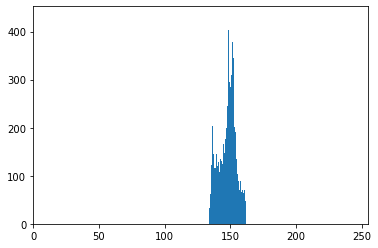

In [317]:
b, bins, patches = plt.hist(summed_and_normilized_all_data_arr_distc, 255)
plt.xlim([0,255])
plt.show()

# Detect images with above avarage outliers + delete them

In [ ]:
images_paths_to_delete_that_are_above_avarage_of_all_classes,
five_images_paths_that_are_ABOVE_avarge_of_all_classes,
five_images_paths_that_are_BELOW_avarge_of_all_classes=return__list_of_paths_of_images_above_avg_ouliers_to_delete_plus_paths_to_best_and_wrost(father_folder_path)

In [ ]:
#delete the images
for i in range(len(images_paths_to_delete_that_are_above_avarage_of_all_classes)):
    img_delete(images_paths_to_delete_that_are_above_avarage_of_all_classes[i])

# Plot 5 images with least outliers and 5 with most outliers

In [ ]:
showImagesHorizontally(five_images_paths_that_are_ABOVE_avarge_of_all_classes[1])

In [ ]:
showImagesHorizontally(five_images_paths_that_are_BELOW_avarge_of_all_classes[1])

# Plot avarage all data intensitiy distribiution after cleanning 

In [ ]:
summed_and_normilized_all_data_arr_distc=plot_class_intensity_distb1(father_folder_path)


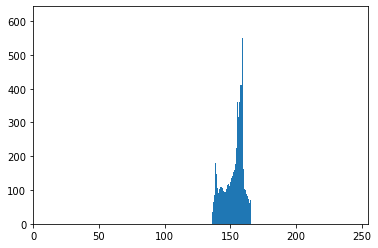

In [493]:
b, bins, patches = plt.hist(summed_and_normilized_all_data_arr_distc, 255)
plt.xlim([0,255])
plt.show()